---
# pRF experiment

This notebook contains an initial analysis of the pRF-data (run-2 and run-5). Each run had 3 iterations of the pRF-design, meaning we will average runs, and iterations.

In [1]:
from linescanning import utils,prf,dataset,plotting
from pRFline import fitting
import numpy as np
import warnings
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy import signal
import os
opj = os.path.join

warnings.simplefilter('ignore')
project_dir = os.environ.get("DIR_PROJECTS")
base_dir = os.path.join(project_dir, 'hemifield')
deriv_dir = opj(base_dir, 'derivatives')

plot_vox = 360
plot_xkcd = False
fig_ext = "pdf"
np.set_printoptions(precision=3)


220413-09:16:32,805 nipype.utils WARNING:
	 A newer version (1.7.1) of nipy/nipype is available. You are using 1.7.0


Fetch the files representing the functional data (`bold.mat` > `call_linerecon`), experiment log file `events.tsv` > `exptools2`), regressor file (`physio.txt`) and mat-file (`physio.mat`) physio files (`call_spmphysio`). `run_files` collects all these files in a list, from which we can then pick the required files and store them in their respective variable

In [3]:
# Load data
sub         = '003'
ses         = 4
task        = "task-pRF"
run         = [4,5,6]
func_dir    = opj(base_dir, f"sub-{sub}", f"ses-{ses}", "func")
anat_dir    = opj(base_dir, f"sub-{sub}", f"ses-{ses}", "anat")
prf_new     = opj(base_dir, 'derivatives', 'prf', f"sub-{sub}", f"ses-{ses}")

if not os.path.exists(prf_new):
    os.makedirs(prf_new, exist_ok=True)

DATASET

FUNCTIONAL
Preprocessing /data1/projects/MicroFunc/Jurjen/projects/hemifield/sub-003/ses-4/func/sub-003_ses-4_task-pRF_run-4_bold.mat
 Filtering strategy: 'lp'
 Cutting 0 volumes from beginning
 DCT-high pass filter [removes low frequencies <0.01 Hz]
 Source dir: /data1/projects/MicroFunc/Jurjen/projects/hemifield/derivatives/nighres/sub-003/ses-1
 Target session: ses-4
 Foldover: FH
 Ref slice: /data1/projects/MicroFunc/Jurjen/projects/hemifield/sub-003/ses-4/anat/sub-003_ses-4_acq-1slice_run-4_T1w.nii.gz
 Trafo's: ['/data1/projects/MicroFunc/Jurjen/projects/hemifield/derivatives/pycortex/sub-003/transforms/sub-003_from-ses1_to-ses4_rec-motion1_desc-genaff.mat', '/data1/projects/MicroFunc/Jurjen/projects/hemifield/sub-003/ses-4/anat/from-run2_to-run4.txt']
 Found 24 voxel for nuisance regression; (indices<300 are ignored due to distance from coil)
 We're good to go!
 Using 5 components for aCompCor (WM/CSF separately)
 Found 1 component(s) in 'csf'-voxels with total explained

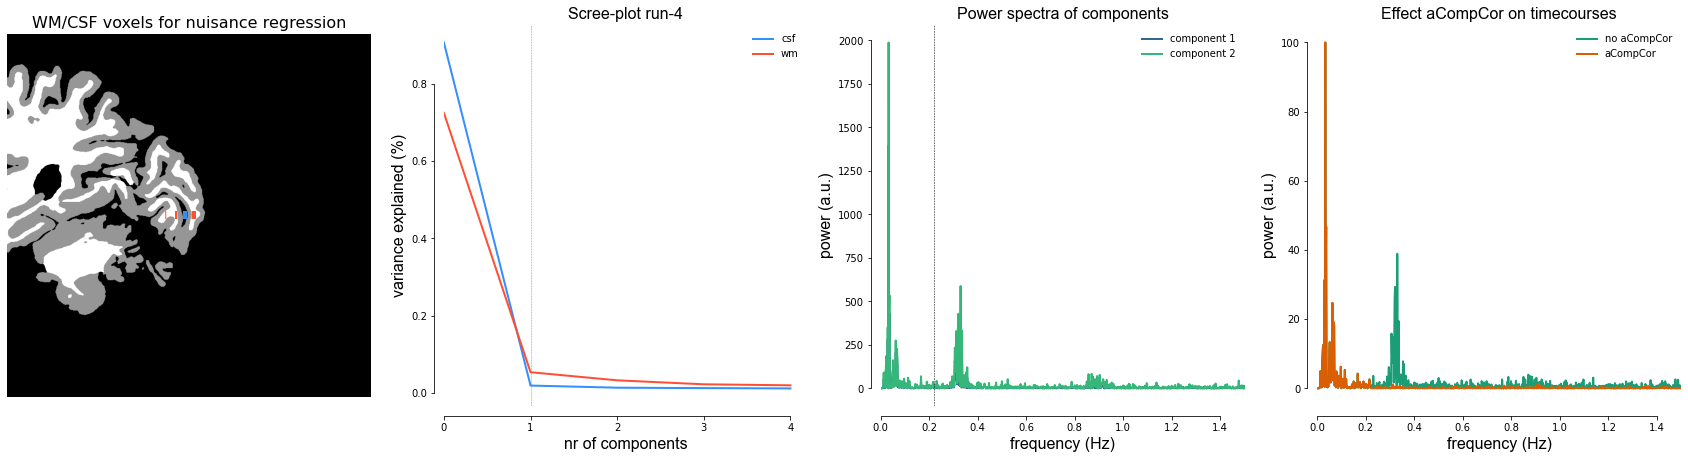

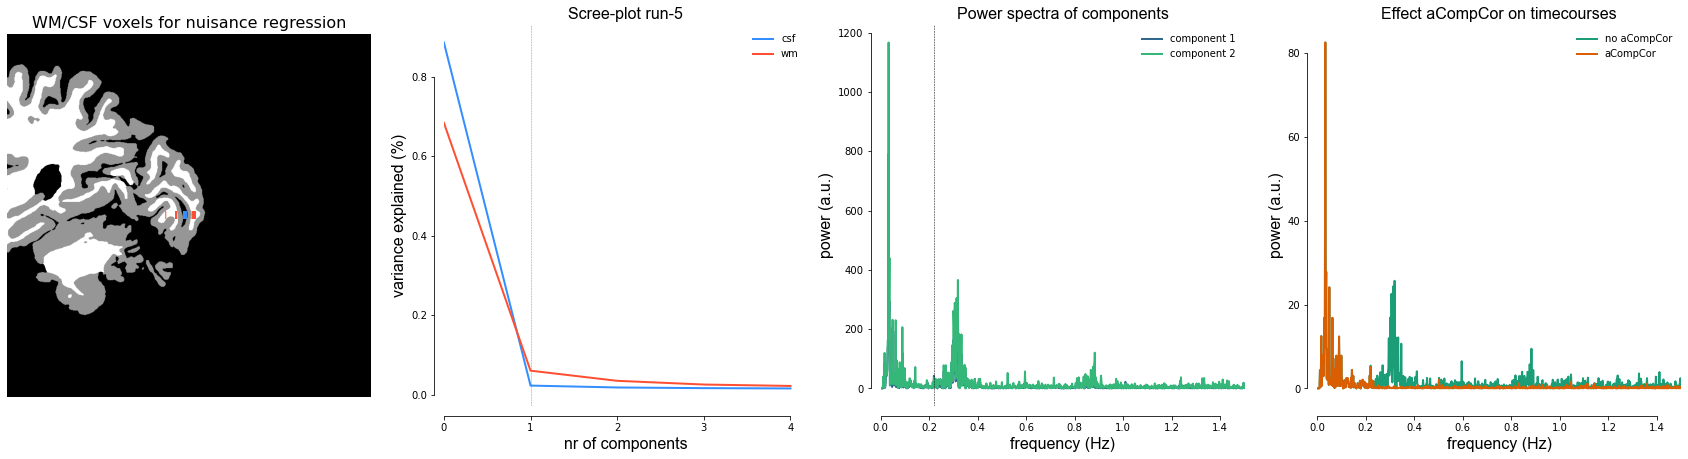

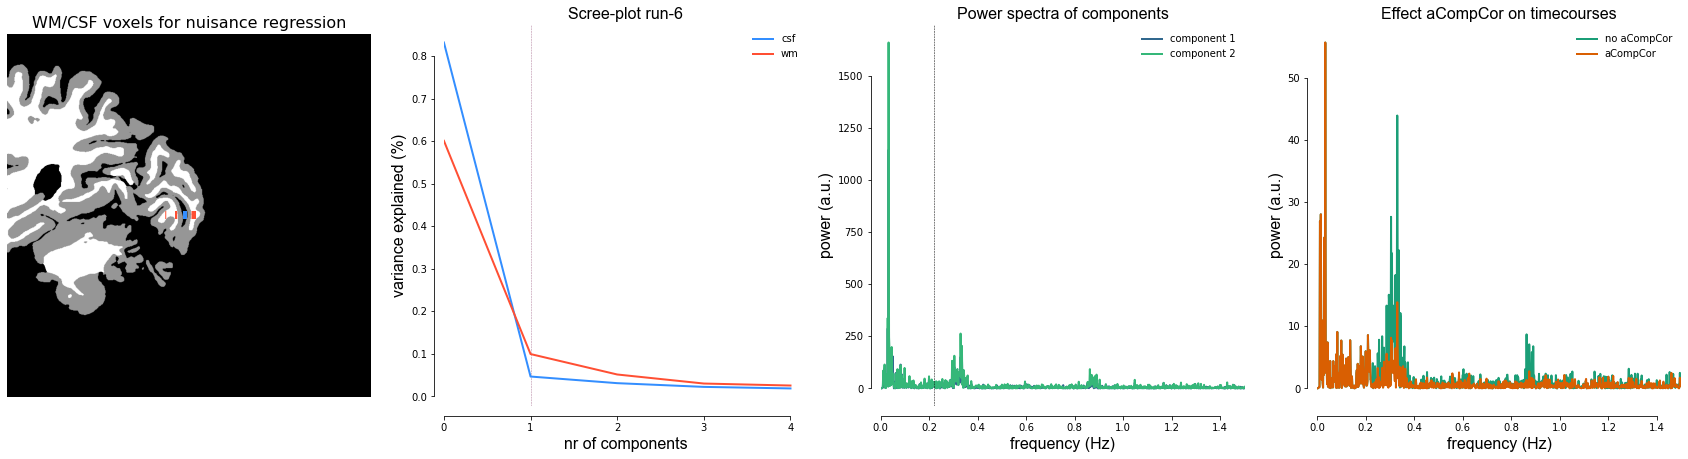

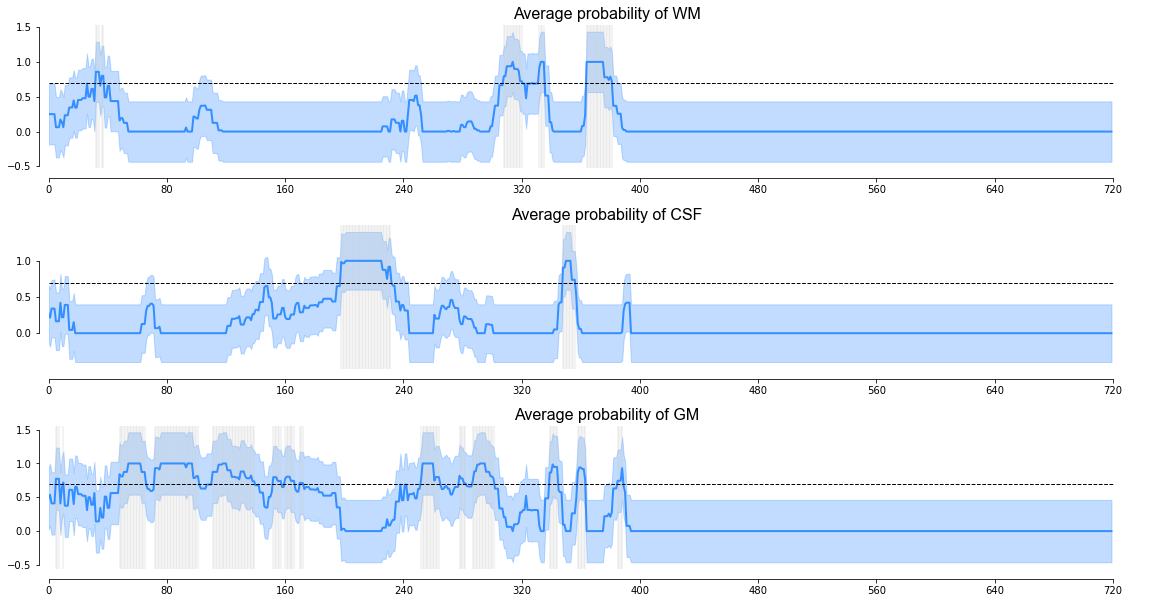

In [24]:
run_files   = utils.get_file_from_substring([f"{task}"], func_dir)
func_file   = [utils.get_file_from_substring([f"run-{i}", "bold.mat"], func_dir) for i in run]
ref_slices  = [utils.get_file_from_substring(["acq-1slice", f"run-{i}", "nii.gz"], anat_dir) for i in run]
log_dir     = "/data1/projects/MicroFunc/Jurjen/projects/hemifield/sourcedata/sub-003/ses-4/sub-003_ses-4_task-pRF_run-imgs"

# get transformation files
trafo = utils.get_file_from_substring(f"ses{ses}_rec-motion1", opj(deriv_dir, 'pycortex', f"sub-{sub}", 'transforms'))
trafo_run   = [utils.get_file_from_substring(f"to-run{i}", anat_dir) for i in run]

# initiate object
window = 19
order = 3

fitter_obj = fitting.FitLines(func_files=func_file,
                              low_pass=True,
                              log_dir=log_dir,
                              baseline_duration=20,
                              iter_duration=240,
                              n_iterations=2,
                              acompcor=True,
                              ref_slice=ref_slices,
                              filter_pca=0.22,
                              ses1_2_ls=trafo,
                              run_2_run=trafo_run,                       
                              poly_order=order,                              
                              rsq_threshold=0,
                              voxel_cutoff=300,
                              verbose=True,
                              output_base=f"sub-{sub}_ses-{ses}_{task}_run-avg",
                              output_dir=prf_new,
                              save_as=opj(anat_dir, f"sub-{sub}_ses-{ses}"))                              

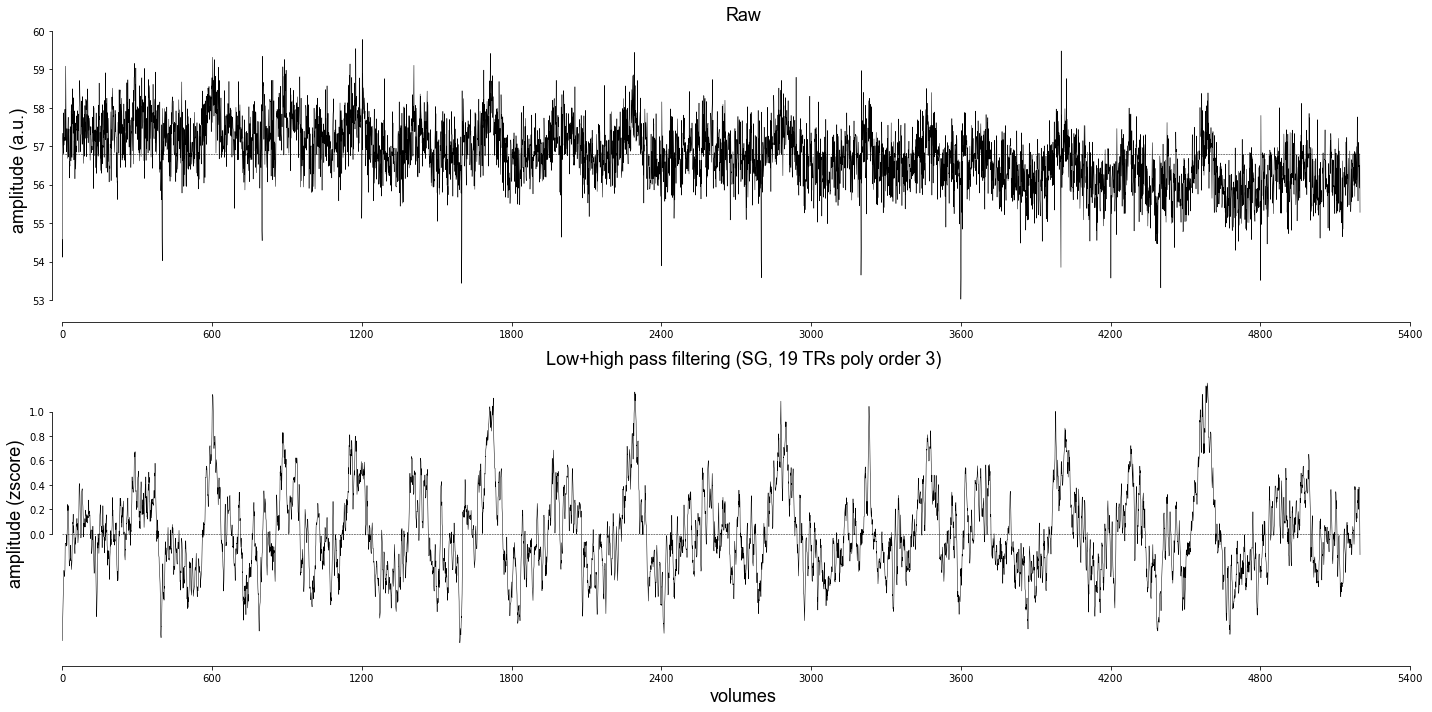

In [25]:
# use this setup so we can add the shaded boxes
fig,axs = plt.subplots(2,1, figsize=(20,10))

# timecourse
plotting.LazyPlot(fitter_obj.df_func_raw.groupby(['subject', 't']).mean()[f'vox {plot_vox}'].values,
                  axs=axs[0],
                  add_hline="mean",
                  line_width=0.5,
                  color="#000000",
                  title="Raw",
                  y_label="amplitude (a.u.)",
                  xkcd=plot_xkcd,
                  sns_trim=True,
                  font_size=18)

plotting.LazyPlot(fitter_obj.df_func_zscore.groupby(['subject', 't']).mean()[f'vox {plot_vox}'].values,
                  axs=axs[1],
                  line_width=0.5,
                  color="#000000",
                  x_label="volumes",
                  title=f"Low+high pass filtering (SG, {window} TRs poly order {order})",
                  y_label="amplitude (zscore)",
                  add_hline='default',
                  xkcd=plot_xkcd,
                  sns_trim=True,
                  font_size=18)                     

plt.tight_layout()
# fig.savefig(opj(func_dir, "filtering.pdf"))

---
# pRF-fitting

Here we fetch relevant pRF-parameters that are required to construct the size-response curve below (this is the same curve as in derivatives/pycortex/<subject>/<subject>_hemi-?_desc-prf_sizeresponse.pdf).

In [20]:
# collect subject data including Normalization parameters
cx_dir = opj(project_dir, 'hemifield', 'derivatives', 'pycortex', f"sub-{sub}")
prf_old = opj(project_dir, 'hemifield', 'derivatives', 'prf', f"sub-{sub}", 'ses-1')
subject_info = utils.CollectSubject(f"sub-{sub}", 
                                    prf_dir=prf_old, 
                                    cx_dir=cx_dir, 
                                    settings='recent', 
                                    hemi="lh", 
                                    model="norm",
                                    verbose=False)

# initiate the SizeResponse class
SR = prf.SizeResponse(subject_info.prf_stim, subject_info.normalization_params, subject_info=subject_info)

# make the stimuli
SR.make_stimuli()

# make the curve
sr_curve1 = SR.make_sr_function(center_prf=True)
sr_curve2 = SR.make_sr_function(center_prf=True, scale_factor=0.8)

# stimsizes are in SR.stims_fill_sizes

Now call `fit()` from `fitter_obj` to create the design matrix and perform the fitting

In [26]:
# do fitting
fitter_obj.fit()

Using data WITHOUT baseline for fitting
Saving data as /data1/projects/MicroFunc/Jurjen/projects/hemifield/derivatives/prf/sub-003/ses-4/sub-003_ses-4_task-pRF_run-avg_desc-data.npy
Using existing design matrix: /data1/projects/MicroFunc/Jurjen/projects/hemifield/derivatives/prf/sub-003/ses-4/sub-003_ses-4_task-pRF_run-avg_desc-design_matrix.npy
Design matrix has shape: (270, 270, 2286)
Shapes of design matrix and functional data match. Ready for fit!
Running fit with norm-model
Setting rsq-threshold to user-defined value: 0
Starting gauss grid fit at 2022/04/13 09:54:08
Gaussian gridfit completed at 2022/04/13 09:56:56. voxels/vertices above 0: 720 out of 720
Gridfit took 0:02:48.450468
Mean rsq>0: 0.16
Save grid-fit parameters in /data1/projects/MicroFunc/Jurjen/projects/hemifield/derivatives/prf/sub-003/ses-4/sub-003_ses-4_task-pRF_run-avg_model-gauss_stage-grid_desc-prf_params.npy
Starting gauss iterfit at 2022/04/13 09:56:56
Gaussian iterfit completed at 2022/04/14 03:12:15. Mean 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   16.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   24.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   32.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   40.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   48.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   55.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed: 34.3min finished


Norm gridfit completed at 2022/04/14 04:13:12. Mean rsq>0: 0.44
Gridfit took 0:34:16.218266
Save grid-fit parameters in /data1/projects/MicroFunc/Jurjen/projects/hemifield/derivatives/prf/sub-003/ses-4/sub-003_ses-4_task-pRF_run-avg_model-norm_stage-grid_desc-prf_params.npy
Starting norm iterfit at 2022/04/14 04:13:12


In [168]:
ribbon_vox = [int(ii.split(' ')[-1]) for ii in list(func.ribbon_df.columns)]
extended_ribbon = [ribbon_vox[0]-1, *ribbon_vox]
extended_ribbon

[359, 360, 361, 362, 363]

In [157]:
sub

'003'

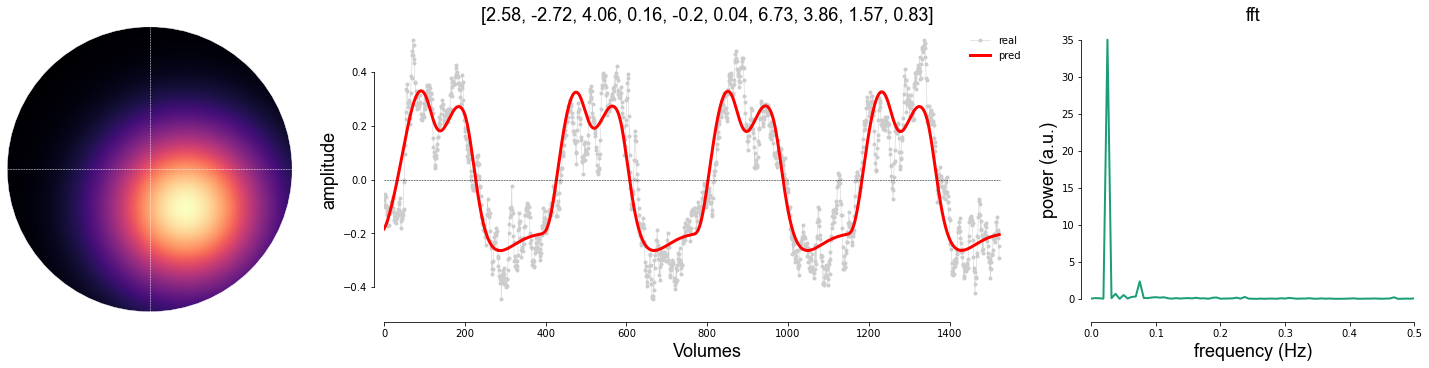

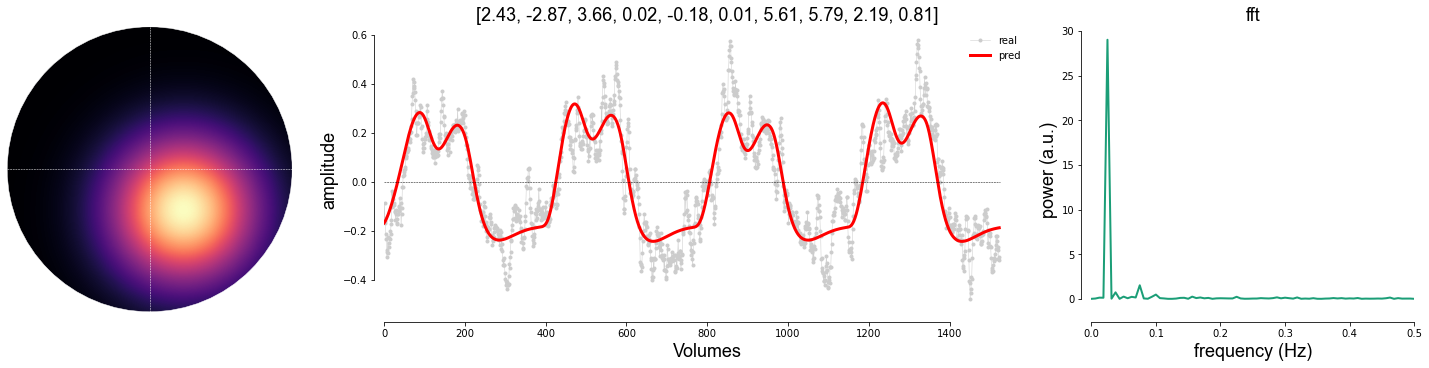

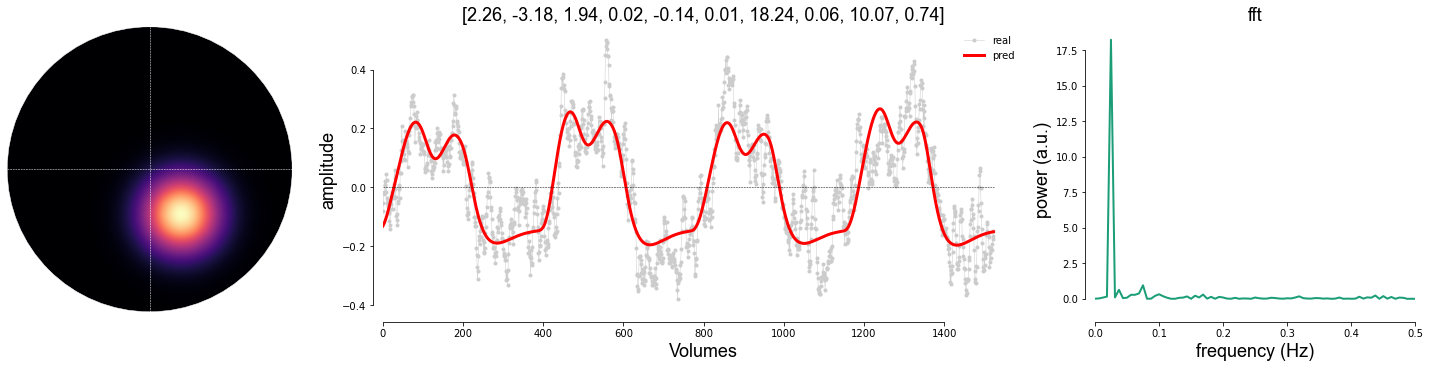

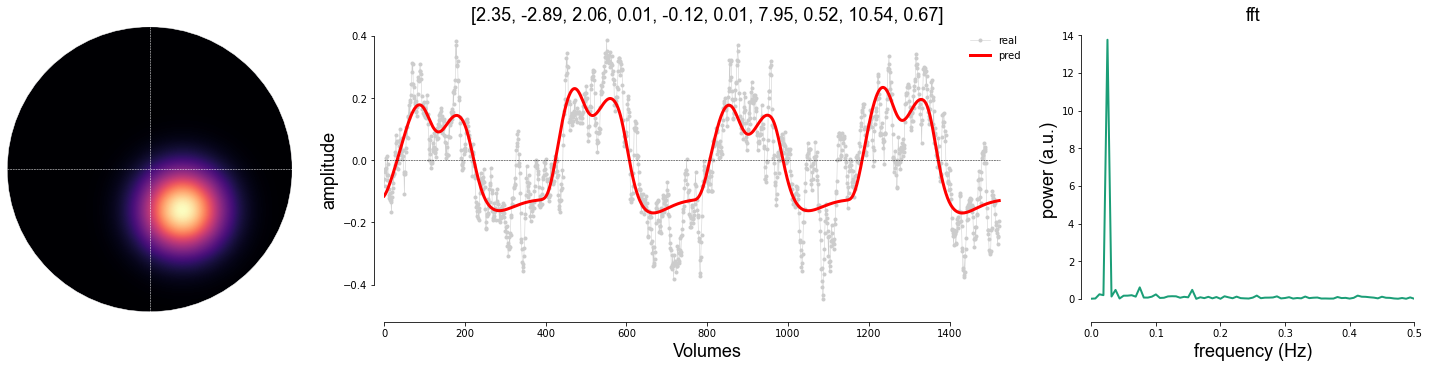

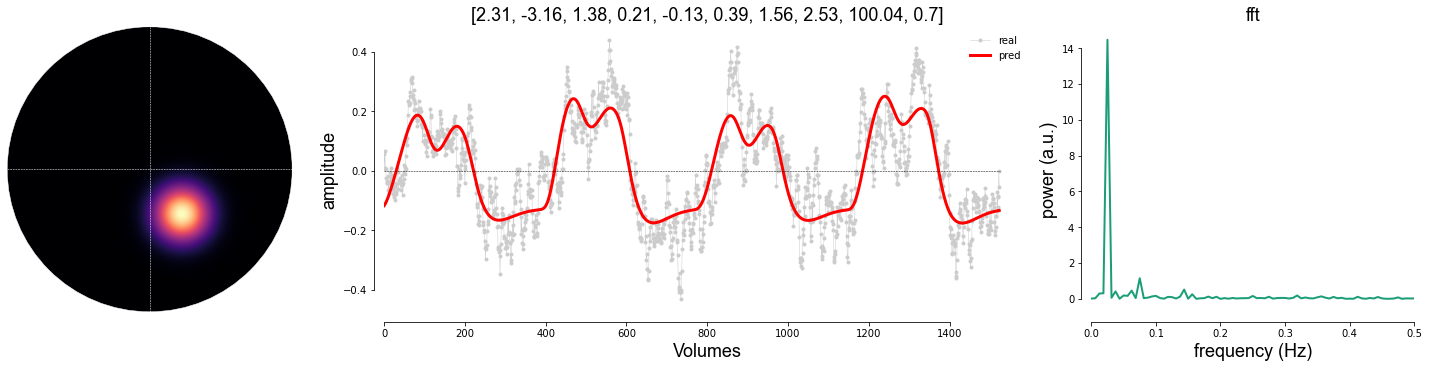

In [164]:
for ix, vox in enumerate(extended_ribbon):
    pars,_,_ = zscore_fit.plot_vox(vox_nr=vox, model='norm', xkcd=False, title='pars', freq_spectrum=True, sns_trim=True, save_as=opj(prf_new, f"sub-{sub}_ses-{ses}_vox-{vox}.{fig_ext}"))

Session 1 - pRF prediction/location:

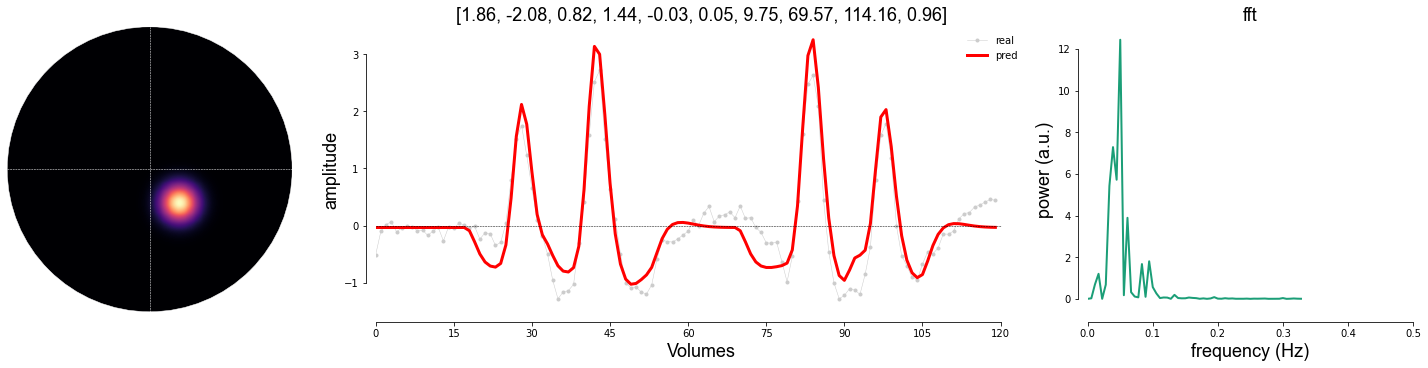

In [165]:
subject_info.target_prediction_prf(xkcd=False, line_width=2, sns_trim=True, freq_spectrum=True, save_as=opj(prf_new, f"sub-{sub}_ses-{ses}_vox-target.{fig_ext}"))

`Vox 359` looks rather similar compared to our target vertex, which is sort of what we wanted. Below I created binary representations of both pRFs for an overlap image

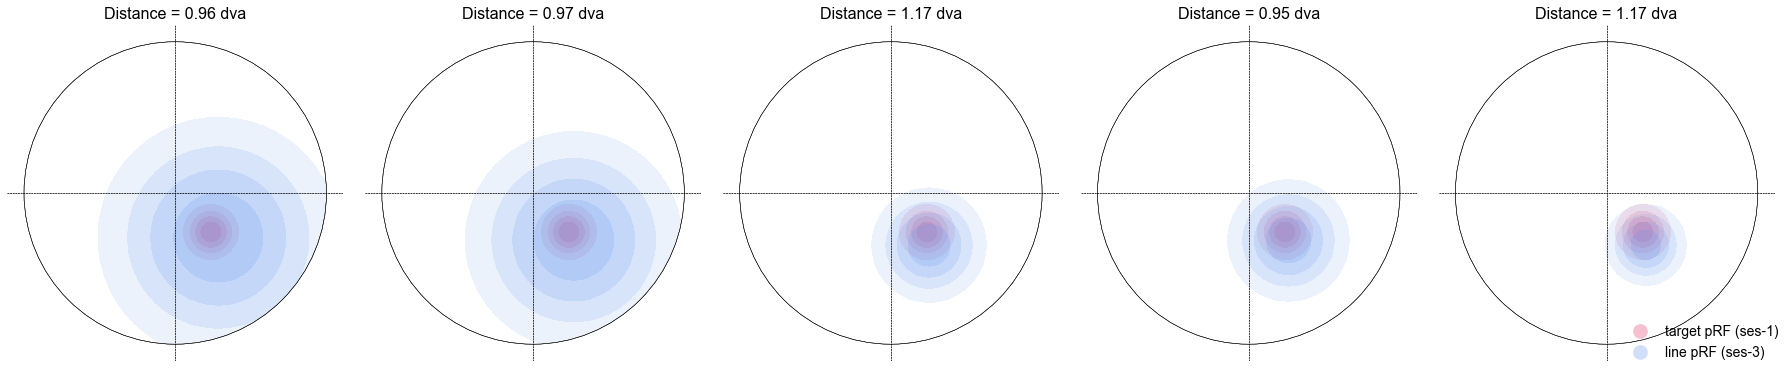

In [166]:
# get linescanning pRF 
fig = plt.figure(figsize=(len(extended_ribbon*5),5))
gs = fig.add_gridspec(1,len(extended_ribbon))

for ix, vox in enumerate(extended_ribbon):
    pars = zscore_fit.norm_iter[vox,...]
    prf_line = prf.make_prf(zscore_fit.prf_stim, size=pars[2], mu_x=pars[0], mu_y=pars[1])

    # get target pRF from ses-1
    prf_target = subject_info.prf_array.copy()

    # create different colormaps
    colors = ["#DE3163", "#6495ED"]
    cmap1 = utils.make_binary_cm(colors[0])
    cmap2 = utils.make_binary_cm(colors[1])
    cmaps = [cmap1, cmap2]
    
    # get distance of pRF-centers
    dist = prf.distance_centers(subject_info.target_params, pars)

    # initiate and plot figure
    axs = fig.add_subplot(gs[ix])
    for ix, obj in enumerate([prf_target,prf_line]):
        plotting.LazyPRF(obj, 
                        vf_extent=subject_info.settings['vf_extent'], 
                        ax=axs, 
                        cmap=cmaps[ix], 
                        cross_color='k', 
                        alpha=0.5, 
                        title=f"Distance = {round(dist, 2)} dva",
                        font_size=16,
                        xkcd=plot_xkcd,
                        shrink_factor=0.9)


# create custom legend
legend_elements = [Line2D([0],[0], marker='o', color='w', label='target pRF (ses-1)', mfc=colors[0], markersize=15, alpha=0.3),
                   Line2D([0],[0], marker='o', color='w', label='line pRF (ses-3)', mfc=colors[1], markersize=15, alpha=0.3)]

# formatting
if plot_xkcd:
    font = "Humor Sans"
else:
    font = "Arial"

L = fig.legend(handles=legend_elements, frameon=False, fontsize=14, loc='lower right')
plt.setp(L.texts, family='Arial')

# overarching title
# fig.suptitle(f"Overlap between target pRF and pRF of line-acquisition (vox {plot_vox})", fontsize=20, fontname=font)

# save img
img = opj(prf_new, f'prf_overlap.{fig_ext}')
fig.savefig(img)
plt.tight_layout()
plt.show()

In [143]:
pars = zscore_fit.norm_iter[extended_ribbon[0]:extended_ribbon[-1]+1,:]
pars_df = prf.SizeResponse.parse_normalization_parameters(pars)
pars_df

,x,y,prf_size,prf_ampl,bold_bsl,neur_bsl,surr_ampl,surr_size,surr_bsl,A,B,C,D,ratio (B/D),r2,size ratio,suppression index
0,2.581467,-2.716852,4.057732,0.158302,-0.198249,3.862536,0.041973,6.731226,-0.198249,0.158302,3.862536,0.041973,1.573947,2.454045,0.830752,1.658864,0.729630
1,2.427699,-2.867464,3.661870,0.023606,-0.180431,5.794229,0.005770,5.611735,-0.180431,0.023606,5.794229,0.005770,2.189218,2.646712,0.807214,1.532478,0.574049
2,2.264550,-3.176508,1.939119,0.020208,-0.144697,0.063485,0.014972,18.238383,-0.144697,0.020208,0.063485,0.014972,10.073047,0.006302,0.741040,9.405502,65.540305
3,2.353826,-2.892625,2.058695,0.013473,-0.124613,0.524649,0.011381,7.950581,-0.124613,0.013473,0.524649,0.011381,10.535688,0.049797,0.670636,3.861952,12.598293
4,2.313856,-3.156581,1.377671,0.205990,-0.128336,2.527839,0.385895,1.558753,-0.128336,0.205990,2.527839,0.385895,100.042791,0.025268,0.703907,1.131441,2.398205


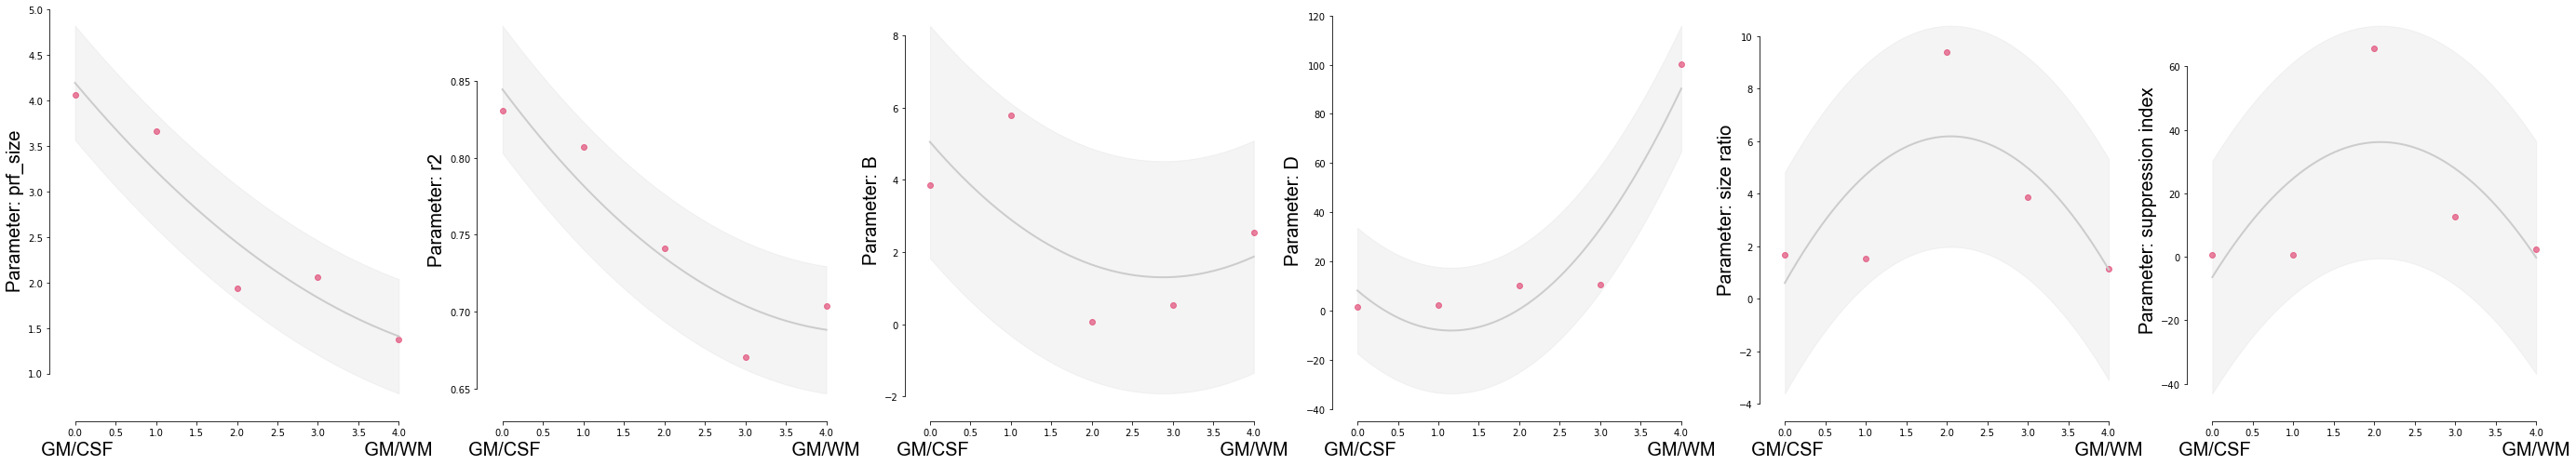

In [173]:
include_params = ["prf_size", "r2", "B", "D", "size ratio", "suppression index"]

fig = plt.figure(figsize=(len(include_params)*8,8))
gs = fig.add_gridspec(1, len(include_params))

for ix,par in enumerate(include_params):
    
    axs = fig.add_subplot(gs[ix])
    vals = pars_df[par].values
    cf = utils.CurveFitter(vals, order=2, verbose=False)

    axs.plot(cf.x, vals, 'o', color=colors[0], alpha=0.6)
    plotting.LazyPlot(cf.y_pred_upsampled,
                    xx=cf.x_pred_upsampled,
                    error=cf.ci_upsampled,
                    axs=axs,
                    color="#cccccc",
                    error_alpha=0.2,
                    x_label="GM/CSF                                                 GM/WM",
                    y_label=f"Parameter: {par}",
                    set_xlim_zero=False,
                    sns_trim=True,
                    line_width=2,
                    xkcd=plot_xkcd,
                    font_size=20)

# save img
# img = opj(prf_new, f'prf_depth.{fig_ext}')
# fig.savefig(img)

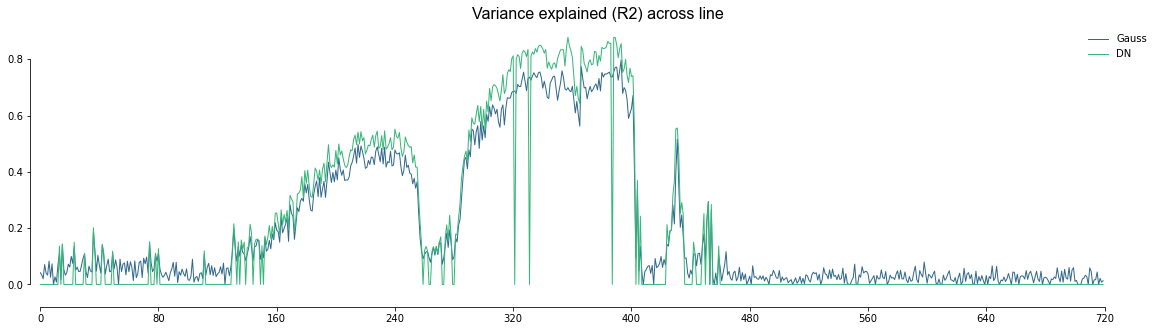

In [170]:
plotting.LazyPlot([zscore_fit.gauss_iter[:,-1], zscore_fit.norm_iter[:,-1]], 
                  sns_trim=True, 
                  title="Variance explained (R2) across line", 
                  font_size=16, 
                  figsize=(20,5),
                  labels=['Gauss', 'DN'])